
## Play with Himawari cloud mask, group data by bins


In [1]:
import os,sys
from glob import glob
#
import xarray as xr
import dask.array as da
#from dask.distributed import Client
from dask.dot import dot_graph
# 
import numpy as np
import cartopy.crs as ccrs
#import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


# jupyter nbconvert --to script hw_cloudmask_agglo.ipynb
# then uncomment matplotlib lines and make sure time indices are right in the main loop


In [2]:
# data path
dpath = '/home1/scratch/aponte/hw/mask/';
figdir = 'figs/'
#figdir = '/home1/datawork/aponte/hw/figs/'
try:
    os.stat(figdir)
except:
    os.mkdir(figdir)
    
filenames = sorted(glob(dpath+'*.nc'))
print 'Number of files available: %d' %len(filenames)
Nfiles = len(filenames)

mask = xr.open_dataset(filenames[0])['QA']
chunks = {'longitude':150,'latitude':100}
mask = mask.chunk(chunks=chunks)

# build time line from filenames and store ut ub tule coordinate
#fname_pref='NC_H08_'+YYYYMM+DD+'_'+hh+mm+'_L2CLPbet_FLDK.02401_02401.nc'
time = [datetime.strptime(f,dpath+'NC_H08_%Y%m%d_%H%M_L2CLPbet_FLDK.02401_02401.nc') for f in filenames]

print mask

Number of files available: 23377
<xarray.DataArray 'QA' (latitude: 2401, longitude: 2401)>
dask.array<xarray-<this-array>, shape=(2401, 2401), dtype=float64, chunksize=(100, 150)>
Coordinates:
  * latitude   (latitude) float32 60.0 59.95 59.9 59.85 59.8 59.75 59.7 ...
  * longitude  (longitude) float32 80.0 80.05 80.1 80.15 80.2 80.25 80.3 ...
Attributes:
    long_name:    Quality Assurance
    units:        Dimensionless
    valid_min:    0
    valid_max:    65535
    description:  (2,1,0) Cloud Retrieval Algorithm Flag: 000=Outside of Scan...


In [3]:
# massage the mask to get cloud flag
rint = xr.ufuncs.rint
fmod = xr.ufuncs.fmod

def process_mask(mask):
    #QA:description = "
    #(2,1,0) Cloud Retrieval Algorithm Flag: 000=Outside of Scan, 001=No Cloud Mask,
    #        010=Clear, 011=Failed, 100=Successful: Low Confidence, 101=Successful: High Confidence, 110=TBD, 111=TBD; 
    #(4,3) Cloud Mask Confidence Level Flag: 00=Clear, 01=Probably Clear, 10=Probably Cloudy, 11=Cloudy; 
    #(6,5) Cloud Retrieval Phase Flag: 00=Clear, 01=Liquid Water, 10=Mixed or Uncertain, 11=Ice; 
    #(7) Spare: 0=TBD, 1=TBD;
    #(8) Sunglint Flag: 0=Yes, 1=No; 
    #(9) Snow Ice Background Possibility Flag: 0=Yes, 1=No; 
    #(11,10) Land/Water Flag: 00=Water, 01=Coastal, 10=TBD, 11=Land; 
    #(12) SOZ>80 or SAZ>70: 0=Yes, 1=No; 
    #(13) Subpixel Inhomogeneity Flag: 0=Yes, 1=No; 
    #(14) Multilayer Cloud Flag: 0=Yes, 1=No; 
    #(15) Inversion Layer Flag: 0=Yes, 1=No;" ;
    #
    fmask=xr.ones_like(mask)
    ### (2,1,0) Cloud Retrieval Algorithm Flag
    code=[]
    for i in xrange(3):
        code.append(rint(fmod(mask,2)))
        mask=mask//2
    fmask = fmask.where( (code[0]==0) & (code[1]==1) & (code[2]==0))
    ### (4,3) Cloud Mask Confidence Level Flag: 00=Clear, 01=Probably Clear, 10=Probably Cloudy, 11=Cloudy;
    code=[]
    for i in xrange(2):
        code.append(rint(fmod(mask,2)))
        mask=mask//2
    #fmask = fmask.where( (code[0]==0) & (code[1]==0) )
    #fmask = fmask.where( code[1]==1 )
    ### skips next
    for i in xrange(5):
        mask=mask//2
    ### (11,10) Land/Water Flag: 00=Water, 01=Coastal, 10=TBD, 11=Land; 
    code=[]
    for i in xrange(2):
        code.append(rint(fmod(mask,2)))
    #    #code.append(np.rint(mask%2))
        mask=mask//2
    fmask = fmask.where( (code[0]==0) & (code[1]==0) )
    #
    fmask = fmask.fillna(0.)
    return fmask

fmask = process_mask(mask)


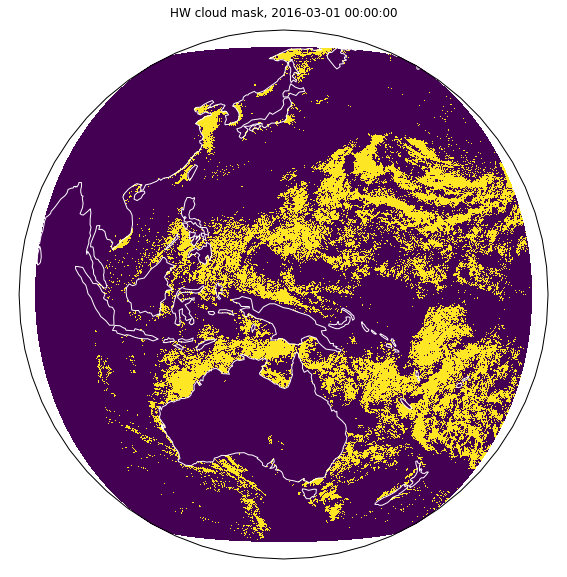

In [4]:
# plot one snapshot

# note, can't download coastlines from cluster nodes:
# wget http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
# (unzip, rename)
# mv 110m_coastline.* ~/.local/share/cartopy/shapefiles/natural_earth/physical/

def plot_mask(mask, colorbar=False, title=None, vmin=0., vmax=1.):
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.Geostationary(central_longitude=140.0));    
    mask.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                         x='longitude', y='latitude', add_colorbar=colorbar);
    ax.coastlines(color='w')
    if title is None:
        #date = str(time[0]).split(':00.')[0].replace('T',' ')
        date = str(time[0])
        ax.set_title('HW cloud mask, '+date)
    else:
        ax.set_title(title)
    plt.show()

# plot
plot_mask(fmask)
plt.savefig(figdir+'hw_snapshot.png')


<xarray.Dataset>
Dimensions:    (latitude: 239, longitude: 239)
Coordinates:
  * longitude  (longitude) float64 80.5 81.0 81.5 82.0 82.5 83.0 83.5 84.0 ...
  * latitude   (latitude) float64 -59.5 -59.0 -58.5 -58.0 -57.5 -57.0 -56.5 ...
Data variables:
    QA         (longitude, latitude) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


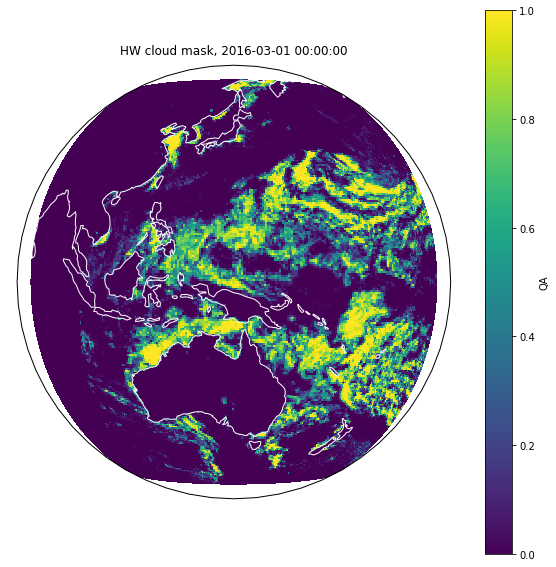

In [5]:
# with dask

# 2D bins
dl = 0.5
#mask['longitude'].max().values
lon_bins = np.arange(fmask['longitude'].min().values, fmask['longitude'].max().values, dl)
lat_bins = np.arange(fmask['latitude'].min().values, fmask['latitude'].max().values, dl)
#
lon_center = lon_bins[:-1]+dl
lat_center = lat_bins[:-1]+dl

def coarsen(fmask):

    # rename
    v1min, v1max, dv1= lon_bins[0], lon_bins[-1], dl
    v2min, v2max, dv2= lat_bins[0], lat_bins[-1], dl
    i1max = int(np.rint((v1max-v1min)/dv1))+1
    i2max = int(np.rint((v2max-v2min)/dv2))+1

    # meshgrid lon/lat, note: need transposing
    fmask = fmask.to_dataset()
    fmask['lon'] = (1.*fmask['longitude'] + 0.*fmask['latitude']).transpose()
    fmask['lat'] = (0.*fmask['longitude'] + 1.*fmask['latitude']).transpose()
    # need rechunking
    fmask = fmask.chunk(chunks)

    def get_index(v1,v2):
            ''' This function provides the index of (v1,v2) coupled value position
            in the 2D histogram array
            '''
            i1 = np.maximum(np.floor((v1-v1min)/dv1)+1,0)
            i1 = np.minimum(i1,i1max)
            i2 = np.maximum(np.floor((v2-v2min)/dv2)+1,0)
            i2 = np.minimum(i2,i2max)
            return i1+i2*(i1max+1)

    # sum QA over coarse grid cells
    v12 = da.map_blocks(get_index, fmask['lon'].data, fmask['lat'].data, dtype='float')
    h, lbins = da.histogram(v12, bins=np.arange(-.5,(i1max+1)*(i2max+1)+0.5,1.), weights=fmask['QA'].data)
    H = h.compute()
    # compute the number of points per grid cells
    hnorm, lbins = da.histogram(v12, bins=np.arange(-.5,(i1max+1)*(i2max+1)+0.5,1.))
    Hnorm = 1.*hnorm.compute()
    Hnorm[np.where(Hnorm==0)]=np.NaN
    # average the mask over coarse grid cells
    H = (H/Hnorm).reshape((i1max+1,i2max+1), order='F')

    cmask = xr.Dataset()
    #cmask['QA'] = (('longitude', 'latitude'), H[1:-1,1:-1].transpose())
    cmask['QA'] = (('longitude', 'latitude'), H[1:-1,1:-1])
    cmask.coords['longitude'] = (('longitude'),lon_center)
    cmask.coords['latitude'] = (('latitude'),lat_center)

    return cmask
    
cmask = coarsen(fmask)
print cmask


#
plot_mask(cmask['QA'],colorbar=True)



In [6]:
# loop over time and store
threshold=.8
Tmin=.5 # in days

# xarray aggregating time intervals
tagg = xr.zeros_like(cmask['QA'])

# reference time
t0 = datetime(2015,7,1,0,0,0)

#
def write_log(slog):
    flog = open('hw_mask.log','a')
    flog.write(slog+'\n')
    flog.close()
    return

#
class twindow_manager():
    def __init__(self):
        self.open = np.empty((0,4))
        self.closed = np.empty((0,4))
    def update(self,lon,lat,delt,time):
        if len(lon)>0:
            for llon, llat, ldelt in zip(lon,lat,delt):
                # test if open is empty
                if self.open.shape[0]>1:
                    # open has 2 elements at least
                    # test if window is already open
                    ij = np.where( (self.open[:,0]==llon) & (self.open[:,1]==llat) )
                    if len(ij[0])==0:
                        # items needs to be added to open list
                        self.open = np.concatenate((self.open,np.array([llon,llat,ldelt,time],ndmin=2)),axis=0)
                    else:
                        # items needs to be updated
                        self.open[ij[0],:] = np.array([llon,llat,ldelt,time])
                elif self.open.shape[0]==1:
                    # open has 1 element
                    if (self.open[0,0]==llon) & (self.open[0,1]==llat):
                        # items needs to be updated
                        self.open[0,:] = np.array([llon,llat,ldelt,time])
                    else:
                        # items needs to be added to open list
                        self.open = np.concatenate((self.open,np.array([llon,llat,ldelt,time],ndmin=2)),axis=0)
                else:
                    # open has 0 elements
                    self.open = np.array([llon,llat,ldelt,time],ndmin=2)
        # need to move inactive windows to closed
        if self.open.shape[0]>0:
            idel=[]
            for i in xrange(self.open[:,0].size):
                # search for matches in lon/lat
                ij = np.where( (lon==self.open[i,0]) & (lat==self.open[i,1]) )
                if len(ij[0])==0:
                    # the window needs to be closed
                    idel.append(i)
                    write_log('Stores: %.2f, %.2f, %.2f, %s ' \
                            %(self.open[i,0],self.open[i,1],self.open[i,2], \
                              str(t0+timedelta(seconds=self.open[i,3])) ) )
            self.open = np.delete(self.open,idel,axis=0)

# init data holder
s = twindow_manager()

# put everything in a function to see if it solves the memory issue
def process(i,f):
    global tagg, im1
    log = str(time[i])
    # load data
    mask = xr.open_dataset(f)['QA']
    # process
    fmask = process_mask(mask)
    # coarsen
    cmask = coarsen(fmask)
    # decimate
    mask = xr.ones_like(cmask['QA'])
    mask = mask.where(cmask['QA']>threshold) # keep only values above the threshold
    mask = mask.fillna(0.)
    #
    if i>0:
        delt = (time[i]-time[im1]).total_seconds()/86400.
        if delt>0.25:
            # reset mask to 0 if time inverval between files exceeds 6h
            mask[:]=0.
        tagg += delt
        tagg *= mask
        tagg.compute()
        # store large values of tagg
        ij = np.where(tagg.values>=Tmin)
        s.update(tagg['longitude'].values[ij[0]], tagg['latitude'].values[ij[1]], \
                 tagg.values[ij], (time[i]-t0).total_seconds())
    #
    im1=i
    log += '  open: %d    closed: %d' %(s.open.shape[0],s.closed.shape[0])
    print '  open: %d    closed: %d' %(s.open.shape[0],s.closed.shape[0])
    write_log(log)
    

In [7]:
# main loop

write_log('dl=%.2f deg, threshold=%.2f, Tmin=%.1f h'%(dl, threshold,Tmin*24.))
#for i,f in enumerate(filenames[:48]):
#for i,f in enumerate(filenames):
for i,f in zip(range(0,6),filenames[:6]):
    process(i,f)
    #print i


  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0
  open: 0    closed: 0


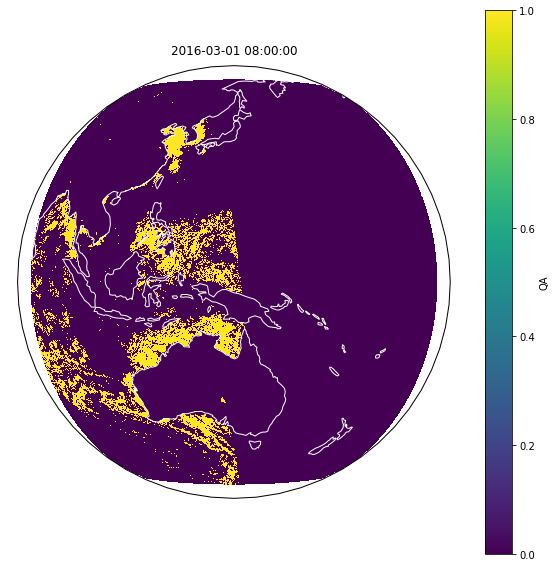

<bound method Dataset.values of <xarray.Dataset>
Dimensions:    (latitude: 239, longitude: 239)
Coordinates:
  * longitude  (longitude) float64 80.5 81.0 81.5 82.0 82.5 83.0 83.5 84.0 ...
  * latitude   (latitude) float64 -59.5 -59.0 -58.5 -58.0 -57.5 -57.0 -56.5 ...
Data variables:
    QA         (longitude, latitude) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...>


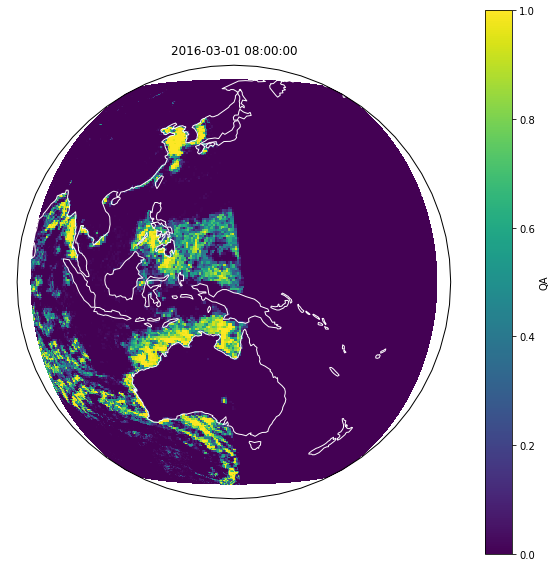

In [8]:
# plot one snapshot, fast

i=15
#i=30
f=filenames[i]

# load data
mask = xr.open_dataset(f)['QA']
# process
fmask = process_mask(mask)
#
plot_mask(fmask,colorbar=True,title=str(time[i]))
plt.savefig(figdir+'hw_fmask_%04d.jpg'%i,dpi=300)
# coarsen
cmask = coarsen(fmask)
print cmask.values
#
plot_mask(cmask['QA'],colorbar=True,title=str(time[i]))
plt.savefig(figdir+'hw_cmask_%04d.jpg'%i,dpi=300)



In [ ]:
# make a movie of the coarsened mask
figdir = '/home1/datawork/aponte/hw/figs/'

#for i,f in enumerate(filenames):
#for i,f in zip(range(0,48*2,12),filenames[:48*2]):
for i,f in enumerate(filenames[:2*24*10]):
    log = str(time[i])
    # load data
    mask = xr.open_dataset(f)['QA']
    # process
    fmask = process_mask(mask)
    # coarsen
    cmask = coarsen(fmask)
    #
    plot_mask(cmask['QA'],colorbar=True,title=log)
    plt.savefig(figdir+'hw_mask_%04d.jpg'%i,dpi=300)
    #
    write_log(log)

In [ ]:
# plot time intervals between files

plt.figure()
ts = np.array([(t-t0).total_seconds()/3600. for t in time])
plt.plot(np.diff(ts))
plt.ylabel('[hour]')
plt.title('Time interval between files')
plt.show()

---

## Old code below

In [ ]:

# bin by latitude with groupby (xarray)

mask_gp = fmask.groupby_bins('latitude', lat_bins, labels=lat_center).mean()
#mask_gp = fmask.groupby_bins('latitude', lat_bins, labels=lat_center)
#print mask_gp
#mask_gp = mask_gp.mean()
#
print mask_gp

plt.figure()
mask_gp.plot()
plt.show()



In [ ]:
# 2D groupby with xarray, coarsening, does not work at the moment
v1min, v1max, dv1= lon_bins[0], lon_bins[-1], dl
v2min, v2max, dv2= lat_bins[0], lat_bins[-1], dl
i1max = int(np.rint((v1max-v1min)/dv1))+1
i2max = int(np.rint((v2max-v2min)/dv2))+1
fmaskt = fmask.copy(deep=True).to_dataset()
fmaskt['ijbin'] = np.minimum(np.maximum(np.floor((fmaskt['longitude']-v1min)/dv1)+1,0),i1max) \
                    +np.minimum(np.maximum(np.floor((fmaskt['latitude']-v2min)/dv2)+1,0),i2max)*(i1max+1)
print fmaskt.QA
print fmaskt.ijbin # not chunked anymore

#print fmaskt
plt.figure()
fmaskt['ijbin'].plot()
plt.show()

## this takes for ever
#mask_gp = fmaskt.groupby_bins('ijbin', np.arange(-.5,(i1max+1)*(i2max+1)+0.5,1.)).mean()
#print mask_gp
